completed file:  PS2/ZatchBell!MamodoFury.txt
completed file:  PS2/Zathura.txt
completed file:  PS2/ZoneoftheEnders.txt
completed file:  PS2/ZoneoftheEndersThe2ndRunner.txt
completed file:  PS2/UEFAEuro2004Portugal.txt
completed file:  PS2/UFCSuddenImpact.txt
completed file:  PS2/UltimateFightingChampionshipThrowdown.txt
completed file:  PS2/UltimateSkySurfer.txt
completed file:  PS2/UltimateSpider-Man.txt
completed file:  PS2/UndertheSkin.txt
completed file:  PS2/UnisonRebelsofRhythm&Dance.txt
completed file:  PS2/UnlimitedSaga.txt
completed file:  PS2/UnrealTournament.txt
completed file:  PS2/UrbanChaosRiotResponse.txt
completed file:  PS2/UrbanReign.txt
completed file:  PS2/V-Rally3.txt
completed file:  PS2/ValkyrieProfile2Silmeria.txt
completed file:  PS2/VampireNight.txt
completed file:  PS2/VanHelsing.txt
completed file:  PS2/Vexx.txt
completed file:  PS2/VictoriousBoxersIppo'sRoadtoGlory.txt
completed file:  PS2/VietcongPurpleHaze.txt
completed file:  PS2/ViewtifulJoe.txt
comple

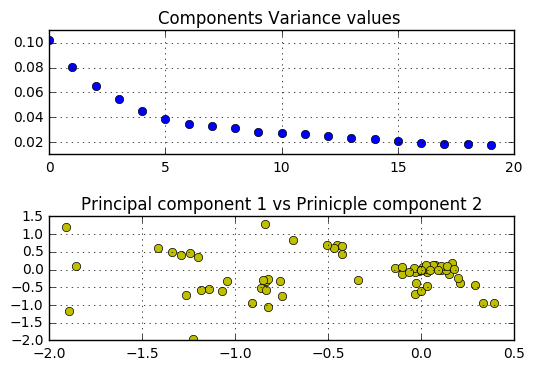

In [1]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType,StringType
from pyspark.ml.feature import CountVectorizer, PCA
from pyspark.mllib.linalg import DenseVector
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Normalizer
import matplotlib.pyplot as plt
from pyspark.mllib.fpm import FPGrowth
import numpy as np
from os import listdir
import os
import string
import errno
path2= "stopwords.txt"


directory_path = "Gamespot-Cleaned/PS2"
review_identification = ":::Review:::"
destination_path  = "Gamespot-Cleaned/Cleaned_Data/" 

break_cond = "-------------------------------------------------"

def get_files(filepath):
    files = []
    files = listdir(filepath)
    return files

def read_content(filepath):
    list_titles = []
    i = 0
    with open(filepath, 'r') as f:
            found_review = False
            for line in f:
                line= line.strip(" ").strip('\n')
                if review_identification in line:
                    found_review = True
                    line = ""
                    next(f)
                if found_review :
                    if line.strip() == break_cond:
                        found_review = False
                        break
                    else:
                        line = line.translate(string.punctuation)
                        list_titles.append([line + " "])
                    #i = i + 1
    return list_titles

def readstopwords():
    list_words = []
    with open(path2, 'r') as f:
            for line in f:
                line= line.strip(" ").strip('\n')
                list_words.append(line)
    return list_words

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

def tokenizeData(data):
    reTokenizer = RegexTokenizer(inputCol= "titles", outputCol="words", pattern="\\W")
    reTokenized = reTokenizer.transform(data)
    return reTokenized
    
def vectorizeData(data, inputColumn, outputColumn):
    vec = CountVectorizer(inputCol = inputColumn, outputCol = outputColumn, vocabSize = 1000, minDF = 2)
    modelVocab = vec.fit(data)
    resultVocab = modelVocab.transform(data)
    #resultVocab.show(truncate=False)
    return resultVocab, modelVocab
    
def pca(data, inputColumn, outputColumn):
    pca = PCA(k = 20, inputCol=inputColumn, outputCol=outputColumn)
    modelPCA = pca.fit(data)
    result = modelPCA.transform(data)
    return result,modelPCA

def get_words_from_vocab(dic , vData):
    dic_final= {}
    vocab = set(vData.vocabulary)
    for entry in dic:
        dic_final[entry] = list(vocab.intersection(dic[entry]))[:15]
    print(dic_final) 

def normalizeData(data, vData):
    wordsperComponent={}
    for entry in data.collect():
        normalizedvalue = 0
        features = list(entry.pcafeatures)
        for val in features:
            normalizedvalue += val * val
        minnormalizevalue = 0.30 * normalizedvalue
        count = 0 
        while(count < len(features)):
            if ((abs(features[count]) >= minnormalizevalue)  and count not in wordsperComponent):
                wordsperComponent[count] = set()
                wordsperComponent[count] |= set(entry.words)
            elif ((abs(features[count]) >= minnormalizevalue)  and count in wordsperComponent):
                wordsperComponent[count] |= set(entry.words)
            count = count + 1
    wordsfinal = get_words_from_vocab(wordsperComponent, vData)
    return wordsperComponent

def write_data_to_file(_data):
    make_sure_path_exists(destination_path)
    with open(destination_path +  directory_path.rsplit('/')[1] + ".txt",'a')  as thefile:
        thefile.write("\n")
        thefile.write("============")
        thefile.write("\n")
        for item in _data:
            thefile.write(item)
    

def get_PCA1and2(data):
    pca1=[]
    pca2=[]
    for entry in data.collect():
        features = list(entry.pcafeatures)
        pca1.append(features[0])
        pca2.append(features[1])  
    return pca1,pca2

def perform_FP_Growth(data,sc):
    rdd = sc.parallelize(list(data.values()))
    model = FPGrowth.train(rdd, minSupport=0.6, numPartitions=1)
    result = model.freqItemsets().collect()
    for t in result:
        print((t.items,t.freq))

def get_fp_growth_data(path):
    dic_txt_data = {}
    filename = path.rsplit("/")[1]
    with open(path, 'r') as f:
        count = 0
        dic = set()
        for line in f:
            if "============" in line.strip(" ").strip("\n"):
                dic_txt_data[count] = dic
                dic = set()
                count = count + 1
            else:
                line= line.strip(" ").strip('\n')
                line = line.split(" ")
                dic = set(line)
            
    return dic_txt_data
def phase_1(spark):
    files = get_files(directory_path)
       
    for f in files: 
        list_titles = read_content(directory_path +"/"+ f)  
        stopwords = readstopwords()
        dataframe = spark.createDataFrame(list_titles,['titles'])
        reTokenized = tokenizeData(dataframe)
        remover = StopWordsRemover(inputCol="words",outputCol="new_titles",stopWords= stopwords)
        df  = remover.transform(reTokenized)
        content = []
        for entry in df.collect():
            txt = ' '.join(entry.new_titles)
            content.append(txt)
        write_data_to_file(content)
        print("completed file: ",directory_path.rsplit("/")[1] +"/" +f)
    return df
def perform_pca(df):
    vectorizedData,modelVocab = vectorizeData(df, "new_titles","vectors")
    value, model = pca(vectorizedData, "vectors", "pcafeatures")
    wordspercomponent = normalizeData(value, modelVocab)
    j = 0 
    k = 0
    totalvariance = sum(model.explainedVariance)
    for x in sorted(model.explainedVariance, reverse=True):
            if(j <= (0.5 * totalvariance)and k < len(model.explainedVariance)):
                j = j + x
                k = k + 1
            elif(j > (0.5 * totalvariance) or k >= len(model.explainedVariance)):
                break
    pca1,pca2 = get_PCA1and2(value)
    plt.subplot(211)
    plt.plot(model.explainedVariance,'bo')
    plt.title("Components Variance values ")
    plt.grid(True)
    plt.subplot(212)
    plt.plot(pca1,pca2, 'yo')
    plt.title("Principal component 1 vs Prinicple component 2")
    plt.grid(True)
    plt.subplots_adjust(wspace = 0.5, hspace=0.5)
    plt.show()

def start_processing():
    SparkContext.setSystemProperty('spark.executor.memory','5g')
    SparkContext.setSystemProperty('spark.driver.memory','15g')
    SparkContext.setSystemProperty('spark.driver.maxResultSize', '5g')
    sc = SparkContext("local","pca")
    spark = SparkSession.builder.getOrCreate()
    df = phase_1(spark)
        
    files = get_files(destination_path)
    for f in files:
        FP_Growth_data = get_fp_growth_data(destination_path + f)
        perform_FP_Growth(FP_Growth_data,sc)
    
    perform_pca(df)   

start_processing()